In [2]:
import pandas as pd
import numpy as np

from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()

In [4]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [12]:
iris.data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [3]:
iris_df = pd.DataFrame(
    data= np.c_[iris['data'], iris['target']],
    columns= iris['feature_names'] + ['target']
    )
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [4]:
iris_df['species'] = iris_df['target'].apply(lambda x: 'setosa' if x==0 else ('versicolor' if x==1 else 'virginica'))
iris_df['species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

# 1. "noise injection" / "noisy data augmentation".

In [7]:
N = 1_000
np.random.seed(2023)
gauss_df = pd.DataFrame(np.resize(np.random.normal(loc=0.0, scale=1.0, size=N*4), (N, 4)))
gauss_df

,0,1,2,3
0,0.711674,-0.324485,-1.001871,0.236251
1,-0.102160,-1.141293,2.654407,1.440605
2,0.098902,-3.121532,-1.076522,-0.325682
3,-1.035498,-0.426320,-1.029361,-0.521774
4,-0.422758,-0.099244,-1.380258,0.301903
...,...,...,...,...
995,0.601130,-0.865946,0.701802,-0.244660
996,0.437431,0.461749,-2.397914,0.842408
997,2.279782,-0.519981,-0.554635,0.669331
998,0.366023,0.452777,1.233735,-0.149967


In [8]:
setosa_gauss_df = iris_df[iris_df['species']=='setosa'].sample(n=N, replace=True, random_state=2023)
setosa_gauss_df['sepal length (cm)'] += gauss_df[0].tolist()
setosa_gauss_df['sepal width (cm)'] += gauss_df[1].tolist()
setosa_gauss_df['petal length (cm)'] += gauss_df[2].tolist()
setosa_gauss_df['petal width (cm)'] += gauss_df[3].tolist()
setosa_gauss_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
23,5.811674,2.975515,0.698129,0.736251,0.0,setosa
25,4.897840,1.858707,4.254407,1.640605,0.0,setosa
6,4.698902,0.278468,0.323478,-0.025682,0.0,setosa
33,4.464502,3.773680,0.370639,-0.321774,0.0,setosa
28,4.777242,3.300756,0.019742,0.501903,0.0,setosa
...,...,...,...,...,...,...
23,5.701130,2.434054,2.401802,0.255340,0.0,setosa
17,5.537431,3.961749,-0.997914,1.142408,0.0,setosa
48,7.579782,3.180019,0.945365,0.869331,0.0,setosa
44,5.466023,4.252777,3.133735,0.250033,0.0,setosa


In [9]:
N2 = 500
np.random.seed(20232)
gauss_df_2 = pd.DataFrame(np.resize(np.random.normal(loc=0.0, scale=1.0, size=N2*4), (N2, 4)))

versicolor_gauss_df = iris_df[iris_df['species']=='versicolor'].sample(n=N2, replace=True, random_state=20232)
versicolor_gauss_df['sepal length (cm)'] += gauss_df_2[0].tolist()
versicolor_gauss_df['sepal width (cm)'] += gauss_df_2[1].tolist()
versicolor_gauss_df['petal length (cm)'] += gauss_df_2[2].tolist()
versicolor_gauss_df['petal width (cm)'] += gauss_df_2[3].tolist()
versicolor_gauss_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
96,4.276196,3.068572,1.900496,3.380141,1.0,versicolor
69,5.415813,2.037630,4.007877,0.279311,1.0,versicolor
95,5.404294,3.107105,3.528240,0.795328,1.0,versicolor
96,5.086108,2.650714,3.701677,0.560030,1.0,versicolor
58,6.409069,1.412966,4.041549,0.881866,1.0,versicolor
...,...,...,...,...,...,...
54,7.110317,2.032726,2.883634,0.629163,1.0,versicolor
56,6.945130,4.193373,6.052742,0.745065,1.0,versicolor
86,6.979033,2.567021,4.241103,3.469673,1.0,versicolor
76,6.737270,2.461805,3.108090,1.260222,1.0,versicolor


# 2. Train autoencoder on setosa

In [10]:
import torch
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class IrisAutoencoder(nn.Module):
    def __init__(self):
        super(IrisAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 2),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [17]:
X = setosa_gauss_df.iloc[:int(N/2)][['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy()
X

array([[ 5.81167353,  2.97551504,  0.69812936,  0.73625079],
       [ 4.89784016,  1.85870737,  4.25440726,  1.64060519],
       [ 4.69890227,  0.27846785,  0.32347835, -0.02568196],
       ...,
       [ 4.96065931,  2.7651612 ,  0.60815656, -0.25318839],
       [ 4.09321464,  2.89690717,  2.30585828,  0.8162469 ],
       [ 4.04743053,  4.41146427,  0.86893815, -0.64907156]])

In [18]:
# Normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test = train_test_split(X, test_size=0.2, random_state=2023)

# Convert to tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)


In [30]:
model = IrisAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10_000
for epoch in range(num_epochs):
    output = model(X_train)
    loss = criterion(output, X_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 1000 == 0:
        print(f'epoch {epoch+1}/{num_epochs}, loss={loss.item():.4f}')


epoch 1000/10000, loss=0.8243
epoch 2000/10000, loss=0.7506
epoch 3000/10000, loss=0.7283
epoch 4000/10000, loss=0.7266
epoch 5000/10000, loss=0.7260
epoch 6000/10000, loss=0.7257
epoch 7000/10000, loss=0.7256
epoch 8000/10000, loss=0.7256
epoch 9000/10000, loss=0.7256
epoch 10000/10000, loss=0.7255


In [32]:
! mkdir /home/mmozolewski/notebooks/jgama/
DATA_DIRECTORY = '/home/mmozolewski/notebooks/jgama/'
torch.save(model.state_dict(), f'{DATA_DIRECTORY}\IrisAutoencoder_v1')

# 3. Visualise losses and cutoff

In [49]:
X_setosa = setosa_gauss_df.iloc[int(N/2):][['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy()
X_versicolor = versicolor_gauss_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy()
X_versicolor

array([[4.27619562, 3.06857233, 1.90049558, 3.38014125],
       [5.41581271, 2.0376301 , 4.00787717, 0.27931071],
       [5.40429387, 3.10710474, 3.52823969, 0.79532768],
       ...,
       [6.9790333 , 2.56702146, 4.24110258, 3.46967272],
       [6.73727018, 2.46180466, 3.10809038, 1.26022235],
       [6.22094096, 1.56504156, 3.37895279, 1.84414599]])

In [50]:
X_setosa = scaler.transform(X_setosa)
X_versicolor = scaler.transform(X_versicolor)

In [51]:
X_setosa_pt = torch.FloatTensor(X_setosa)
X_versicolor_pt = torch.FloatTensor(X_versicolor)

In [52]:
def print_loss(X_tensor):
    model.eval()
    with torch.no_grad():
        output = model(X_tensor)
        loss = criterion(output, X_tensor)

    print('Test Loss:', loss.item())

print_loss(X_setosa_pt)
print_loss(X_versicolor_pt)

Test Loss: 0.7615812420845032
Test Loss: 1.127249002456665


In [53]:
def get_losses(X_tensor):
    losses = []
    with torch.no_grad():
        for sample in X_tensor:
            output = model(sample)
            loss = criterion(output, sample)
            losses.append(loss.item())

    # Choose a cutoff value
    cutoff = sum(losses) / len(losses)
    print('Cutoff Loss:', cutoff)

    return losses, cutoff

losses_setosa, cutoff_setosa = get_losses(X_setosa_pt)
losses_versicolor, cutoff_versicolor = get_losses(X_versicolor_pt)

Cutoff Loss: 0.7615812552487478
Cutoff Loss: 1.127248913921416


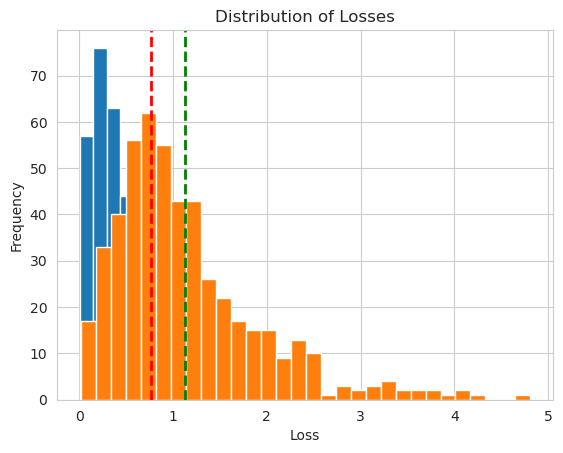

In [54]:
import matplotlib.pyplot as plt

plt.hist(losses_setosa, bins=30)
plt.hist(losses_versicolor, bins=30)
plt.axvline(cutoff_setosa, color='r', linestyle='dashed', linewidth=2)
plt.axvline(cutoff_versicolor, color='g', linestyle='dashed', linewidth=2)
plt.title('Distribution of Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()

Cutoff Loss: 0.9444150845850818


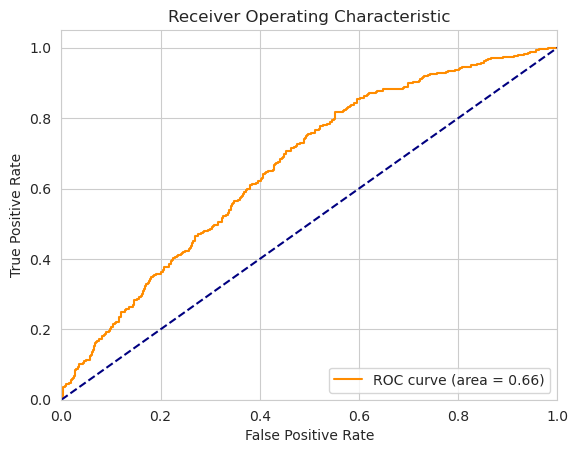

In [55]:
from sklearn.metrics import roc_curve, auc

# Concatenate to form the test set
X_test = np.concatenate((X_setosa, X_versicolor))
y_test = np.concatenate((np.zeros(len(X_setosa)), np.ones(len(X_versicolor))))

# Convert to tensors
X_test = torch.FloatTensor(X_test)

losses, _ = get_losses(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, losses, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
